In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from functools import partial

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
from metal.mmtl.metal_model import MetalModel
from metal.mmtl.slicing.slice_model import SliceModel
from metal.mmtl.trainer import MultitaskTrainer
from metal.mmtl.slicing.synthetics.mmtl_utils import create_tasks, create_payloads, remap_labelsets
from metal.mmtl.slicing.synthetics.data_generator import generate_data, get_circle_mask
from metal.mmtl.slicing.synthetics.viz import visualize_payload, visualize_predictions, visualize_attention, score_and_visualize

In [5]:
from metal.utils import set_seed

seed = 123
set_seed(seed)

In [6]:
# targets all the data -- used to add the BASE labelset to payloads
identity_fn = lambda x: np.ones(x.shape[0], dtype=np.bool)
# NOTE: the slice function _imperfectly_ targets the critical slice area.
critical_slice_fn = partial(get_circle_mask, center=(0.35, -0.1), radius=0.2)

### Generate Synthetic Dataset
We aim to build a dataset with a linear decision boundary and an abnormal boundary around $x=0.25, y=0$.
We define this slice as our `critical_region`.

In [7]:
decision_boundary_flip = partial(get_circle_mask, center=(0.25, 0), radius=0.2)
uid_lists, Xs, Ys = generate_data(N=5000, decision_boundary_flip=decision_boundary_flip)
task_name = "test_task"

#### Generate eval payload over the `critical_slice`

In [8]:
eval_payload = create_payloads(task_name, uid_lists, Xs, Ys, batch_size=4, 
   slice_funcs={"critical_slice": critical_slice_fn}
)[2] # take test set

Vizualizing labelset_gold from payload_test


/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


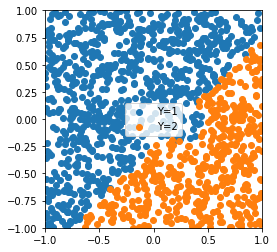

Vizualizing labelset:critical_slice:ind from payload_test


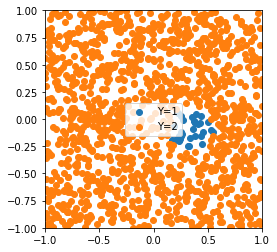

Vizualizing labelset:critical_slice:pred from payload_test


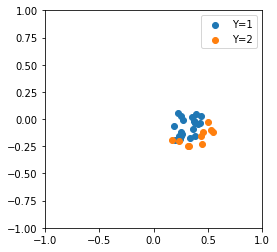

In [9]:
visualize_payload(eval_payload)

### Initialize and train each model type

In [10]:
# all models to test to test
model_configs = {
    'soft_param': {
        'slice_funcs': {"critical_slice": critical_slice_fn, "BASE": identity_fn},
        'model_class': SliceModel   
    },
    'hard_param': {
        'slice_funcs': {"critical_slice": critical_slice_fn, "BASE": identity_fn},
        'model_class': MetalModel
    },
    'naive': {
        'slice_funcs': {},
        'model_class': MetalModel   
    },
}

==========Initializing + Training soft_param==========
Creating 5 tasks...
BinaryClassificationTask(name=test_task, loss_multiplier=1.00, slice_head_type=None)
BinaryClassificationTask(name=test_task:critical_slice:pred, loss_multiplier=0.25, slice_head_type=pred)
BinaryClassificationTask(name=test_task:critical_slice:ind, loss_multiplier=0.25, slice_head_type=ind)
BinaryClassificationTask(name=test_task:BASE:pred, loss_multiplier=0.25, slice_head_type=pred)
BinaryClassificationTask(name=test_task:BASE:ind, loss_multiplier=0.25, slice_head_type=ind)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:critical_slice:ind': 'test_task:critical_slice:ind', 'labelset:critical_slice:pred': 'test_task:critical_slice:pred', 'labelset:BASE:ind': 'test_task:BASE:ind', 'labelset:BASE:pred': 'test_task:BASE:pred'}], split=train)
Payload(payload_valid: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:critical_slice:ind': 'test_task:critic

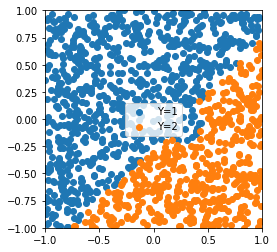

Vizualizing labelset:critical_slice:ind from payload_valid


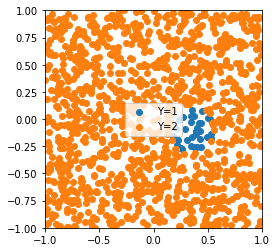

Vizualizing labelset:critical_slice:pred from payload_valid


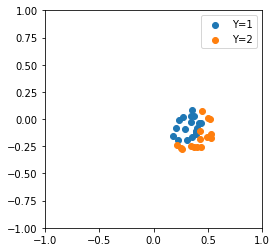

Vizualizing labelset:BASE:ind from payload_valid


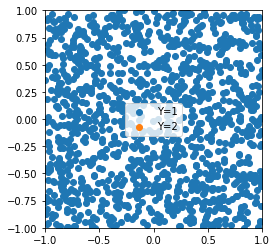

Vizualizing labelset:BASE:pred from payload_valid


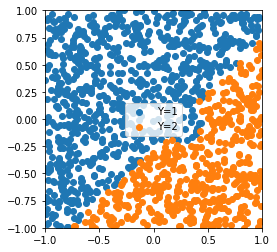

No cuda device available. Using cpu instead.

Network architecture:
SliceModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:BASE:ind): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:BASE:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:critical_slice:ind): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:critical

[8.0 epo]: test_task:[payload_train/labelset_gold/loss=5.52e-02, payload_valid/labelset_gold/accuracy=9.85e-01] test_task:critical_slice:ind:[payload_train/labelset:critical_slice:ind/loss=1.93e-02, payload_valid/labelset:critical_slice:ind/accuracy=9.74e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.94e-05, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.65e-02, payload_valid/labelset:BASE:pred/accuracy=9.78e-01] test_task:critical_slice:pred:[payload_train/labelset:critical_slice:pred/loss=7.57e-02, payload_valid/labelset:critical_slice:pred/accuracy=7.27e-01] model:[train/all/loss=2.31e-02, train/all/lr=1.00e-02]
[9.0 epo]: test_task:[payload_train/labelset_gold/loss=5.41e-02, payload_valid/labelset_gold/accuracy=9.85e-01] test_task:critical_slice:ind:[payload_train/labelset:critical_slice:ind/loss=1.74e-02, payload_valid/labelset:critical_slice:ind/accuracy=9.74e-01] test_task:BASE:ind:[payload_train/l

[20.0 epo]: test_task:[payload_train/labelset_gold/loss=3.61e-02, payload_valid/labelset_gold/accuracy=9.94e-01] test_task:critical_slice:ind:[payload_train/labelset:critical_slice:ind/loss=9.15e-03, payload_valid/labelset:critical_slice:ind/accuracy=9.86e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=9.32e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.49e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01] test_task:critical_slice:pred:[payload_train/labelset:critical_slice:pred/loss=5.35e-02, payload_valid/labelset:critical_slice:pred/accuracy=7.27e-01] model:[train/all/loss=1.56e-02, train/all/lr=1.00e-02]
[21.0 epo]: test_task:[payload_train/labelset_gold/loss=3.50e-02, payload_valid/labelset_gold/accuracy=9.94e-01] test_task:critical_slice:ind:[payload_train/labelset:critical_slice:ind/loss=8.91e-03, payload_valid/labelset:critical_slice:ind/accuracy=9.86e-01] test_task:BASE:ind:[payload_train

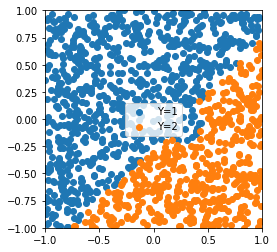

Vizualizing labelset:critical_slice:ind from payload_valid


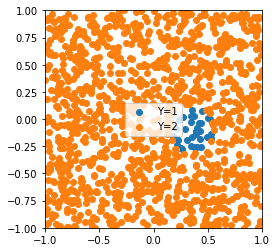

Vizualizing labelset:critical_slice:pred from payload_valid


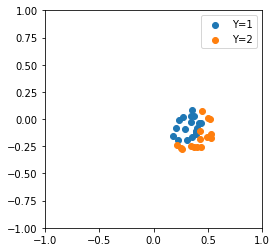

Vizualizing labelset:BASE:ind from payload_valid


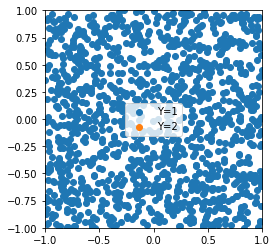

Vizualizing labelset:BASE:pred from payload_valid


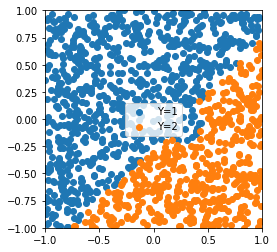

No cuda device available. Using cpu instead.

Network architecture:
MetalModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:BASE:ind): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:BASE:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:critical_slice:ind): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:critical

[8.0 epo]: test_task:[payload_train/labelset_gold/loss=6.61e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:critical_slice:ind:[payload_train/labelset:critical_slice:ind/loss=2.34e-02, payload_valid/labelset:critical_slice:ind/accuracy=9.74e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.61e-05, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.65e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01] test_task:critical_slice:pred:[payload_train/labelset:critical_slice:pred/loss=6.21e-02, payload_valid/labelset:critical_slice:pred/accuracy=7.58e-01] model:[train/all/loss=2.68e-02, train/all/lr=1.00e-02]
[9.0 epo]: test_task:[payload_train/labelset_gold/loss=6.69e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:critical_slice:ind:[payload_train/labelset:critical_slice:ind/loss=2.31e-02, payload_valid/labelset:critical_slice:ind/accuracy=9.74e-01] test_task:BASE:ind:[payload_train/l

[20.0 epo]: test_task:[payload_train/labelset_gold/loss=7.01e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:critical_slice:ind:[payload_train/labelset:critical_slice:ind/loss=2.14e-02, payload_valid/labelset:critical_slice:ind/accuracy=9.74e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.12e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.75e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01] test_task:critical_slice:pred:[payload_train/labelset:critical_slice:pred/loss=5.03e-02, payload_valid/labelset:critical_slice:pred/accuracy=7.58e-01] model:[train/all/loss=2.74e-02, train/all/lr=1.00e-02]
[21.0 epo]: test_task:[payload_train/labelset_gold/loss=7.01e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:critical_slice:ind:[payload_train/labelset:critical_slice:ind/loss=2.13e-02, payload_valid/labelset:critical_slice:ind/accuracy=9.74e-01] test_task:BASE:ind:[payload_train

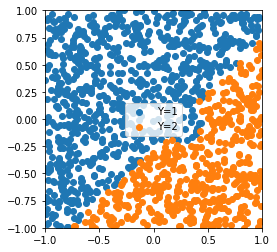

No cuda device available. Using cpu instead.

Network architecture:
MetalModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
  )
  (middle_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): IdentityModule()
      )
    )
  )
  (attention_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): IdentityModule()
      )
    )
  )
  (head_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Linear(in_features=5, out_features=1, bias=True)
      )
    )
  )
)

Total number of parameters: 21
Beginning train loop.
Expecting a total of approximately 2500 examples and 625 batches per epoch from 1 payload(s) in the train split.
[1.0 epo]: test_task

In [11]:
%%time
trained_models = {}
for model_name, config in model_configs.items():
    print(f"{'='*10}Initializing + Training {model_name}{'='*10}")
    slice_funcs = config['slice_funcs']
    model_class = config['model_class']
    tasks = create_tasks(task_name, slice_names=list(slice_funcs.keys()), verbose=True)
    payloads = create_payloads(task_name, uid_lists, Xs, Ys, batch_size=4, slice_funcs=slice_funcs, verbose=True)
    visualize_payload(payloads[1])
    model = model_class(tasks, verbose=True, seed=seed)
    trainer = MultitaskTrainer(verbose=True, lr=0.01, seed=seed)
    metrics_dict = trainer.train_model(
        model, payloads, n_epochs=30, verbose=True
    )
    print(metrics_dict)
          
    trained_models[model_name] = model

### Confirm that slice heads are actually experts at their jobs...

labelset 'labelset_gold' -> task 'test_task:critical_slice:pred' (originally, test_task).
labelset 'labelset:critical_slice:ind' -> task 'None' (originally, test_task:critical_slice:ind).
==========Evaluating soft_param==========
Eval mapping...
{   'labelset:critical_slice:ind': None,
    'labelset:critical_slice:pred': 'test_task:critical_slice:pred',
    'labelset_gold': 'test_task:critical_slice:pred'}
Model Scores:
{   'test_task:critical_slice:pred/payload_test/labelset:critical_slice:pred/accuracy': 0.875,
    'test_task:critical_slice:pred/payload_test/labelset_gold/accuracy': 0.912}
Vizualizing test_task:critical_slice:pred predictions on labelset_gold


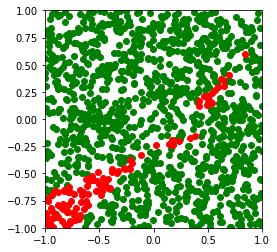

Vizualizing test_task:critical_slice:pred predictions on labelset:critical_slice:pred


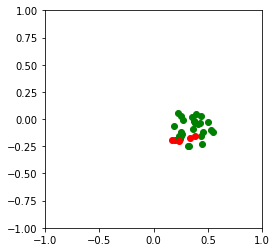

==========Evaluating hard_param==========
Eval mapping...
{   'labelset:critical_slice:ind': None,
    'labelset:critical_slice:pred': 'test_task:critical_slice:pred',
    'labelset_gold': 'test_task:critical_slice:pred'}
Model Scores:
{   'test_task:critical_slice:pred/payload_test/labelset:critical_slice:pred/accuracy': 0.875,
    'test_task:critical_slice:pred/payload_test/labelset_gold/accuracy': 0.9064}
Vizualizing test_task:critical_slice:pred predictions on labelset_gold


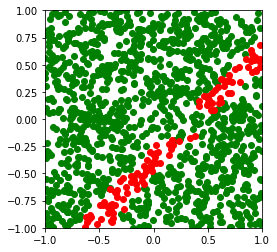

Vizualizing test_task:critical_slice:pred predictions on labelset:critical_slice:pred


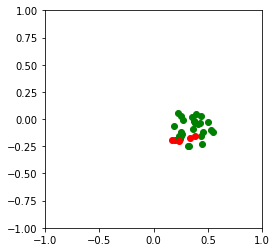

In [12]:
remap_labelsets( 
    eval_payload,
    labels_to_tasks = {
        "labelset_gold": "test_task:critical_slice:pred",
        "labelset:critical_slice:pred": "test_task:critical_slice:pred"
    }
)

for model_name in model_configs.keys():
    if model_name in ["hard_param", "soft_param"]:
        print(f"{'='*10}Evaluating {model_name}{'='*10}")
        score_and_visualize(trained_models[model_name], eval_payload)

### Evaluate model on primary task head

labelset 'labelset_gold' -> task 'test_task' (originally, test_task:critical_slice:pred).
labelset 'labelset:critical_slice:pred' -> task 'test_task' (originally, test_task:critical_slice:pred).
==========Evaluating soft_param==========
Eval mapping...
{   'labelset:critical_slice:ind': None,
    'labelset:critical_slice:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:critical_slice:pred/accuracy': 0.71875,
    'test_task/payload_test/labelset_gold/accuracy': 0.9912}
Vizualizing test_task predictions on labelset_gold


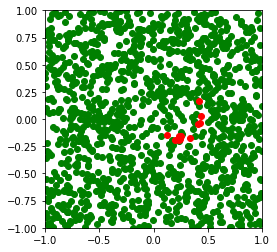

Vizualizing test_task predictions on labelset:critical_slice:pred


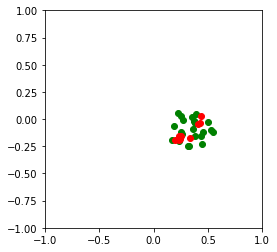

==========Evaluating hard_param==========
Eval mapping...
{   'labelset:critical_slice:ind': None,
    'labelset:critical_slice:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:critical_slice:pred/accuracy': 0.4375,
    'test_task/payload_test/labelset_gold/accuracy': 0.9712}
Vizualizing test_task predictions on labelset_gold


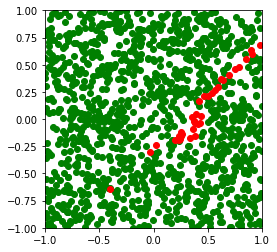

Vizualizing test_task predictions on labelset:critical_slice:pred


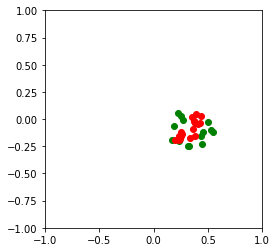

==========Evaluating naive==========
Eval mapping...
{   'labelset:critical_slice:ind': None,
    'labelset:critical_slice:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:critical_slice:pred/accuracy': 0.4375,
    'test_task/payload_test/labelset_gold/accuracy': 0.972}
Vizualizing test_task predictions on labelset_gold


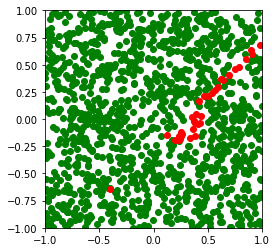

Vizualizing test_task predictions on labelset:critical_slice:pred


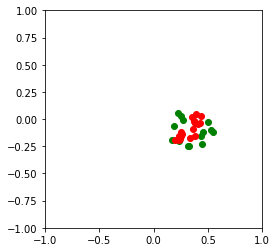

In [13]:
# map all labelsets to the primary task_head 
remap_labelsets(eval_payload, 
    labels_to_tasks= {
        "labelset_gold": "test_task",
        "labelset:critical_slice:pred": "test_task"
    }
)

for model_name in model_configs.keys():
    print(f"{'='*10}Evaluating {model_name}{'='*10}")
    score_and_visualize(trained_models[model_name], eval_payload)

### Visualize Attention Weights of `soft_param`

Vizualizing test_task:BASE:ind attention on labelset_gold


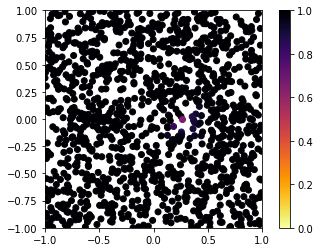

Vizualizing test_task:critical_slice:ind attention on labelset_gold


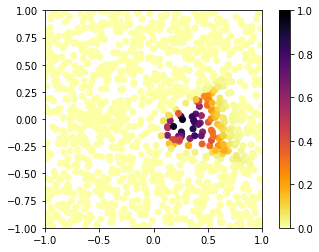

Vizualizing test_task:BASE:ind attention on labelset:critical_slice:pred


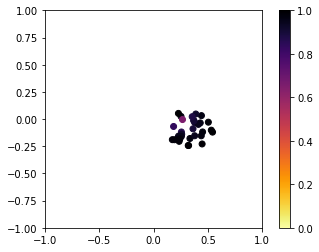

Vizualizing test_task:critical_slice:ind attention on labelset:critical_slice:pred


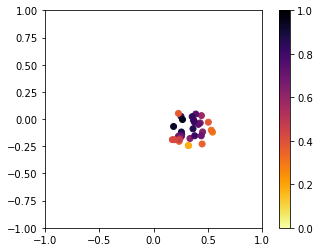

In [14]:
visualize_attention(trained_models['soft_param'], eval_payload)